## SETUP

In [ ]:
!pip install gym[classic_control]
!pip install dezero

In [7]:
import matplotlib.pyplot as plt

# utility functions (common functions)
def plot_total_reward(reward_history):
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(range(len(reward_history)), reward_history)
    plt.show()

In [15]:
class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.pi)

    def get_action(self, state):
        state = state[np.newaxis, :]
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        self.pi.cleargrads()

        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G

        for reward, prob in self.memory:
            loss += -F.log(prob) * G

        loss.backward()
        self.optimizer.update()
        self.memory = []


## ch09/simple_pg.py

In [3]:
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L


class Policy(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x))
        return x


class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.pi)

    def get_action(self, state):
        state = state[np.newaxis, :]
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        self.pi.cleargrads()

        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G

        for reward, prob in self.memory:
            loss += -F.log(prob) * G

        loss.backward()
        self.optimizer.update()
        self.memory = []

In [17]:
env = gym.make('CartPole-v0')
state = env.reset()
agent = Agent()
reward_history = []
action, prob = agent.get_action(state)
print('action', action)
print('prob', prob)

G = 100 # 虚拟权重
J = G * F.log(prob)
print('J:',J)

J.backward()

action 0
prob variable(0.48403681745125177)
J: variable(-72.55943060444572)


episode :0, total reward : 38.0
episode :100, total reward : 15.0
episode :200, total reward : 25.0
episode :300, total reward : 59.0
episode :400, total reward : 11.0
episode :500, total reward : 73.0
episode :600, total reward : 56.0
episode :700, total reward : 64.0
episode :800, total reward : 129.0
episode :900, total reward : 39.0
episode :1000, total reward : 30.0
episode :1100, total reward : 44.0
episode :1200, total reward : 47.0
episode :1300, total reward : 133.0
episode :1400, total reward : 76.0
episode :1500, total reward : 82.0
episode :1600, total reward : 94.0
episode :1700, total reward : 183.0
episode :1800, total reward : 44.0
episode :1900, total reward : 18.0
episode :2000, total reward : 121.0
episode :2100, total reward : 147.0
episode :2200, total reward : 32.0
episode :2300, total reward : 97.0
episode :2400, total reward : 200.0
episode :2500, total reward : 104.0
episode :2600, total reward : 86.0
episode :2700, total reward : 159.0
episode :2800, total rew

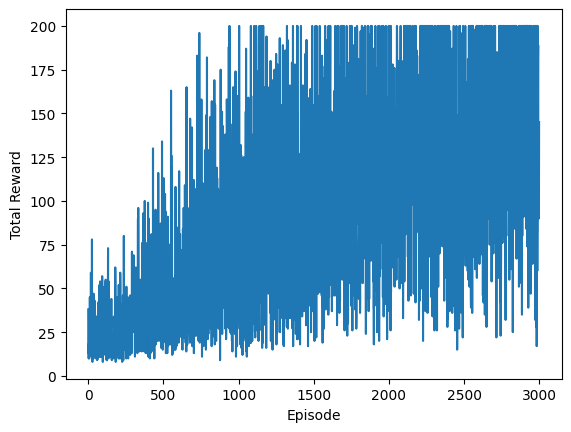

In [18]:
episodes = 3000
env = gym.make('CartPole-v0')
agent = Agent()
reward_history = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.add(reward, prob)
        state = next_state
        total_reward += reward

    agent.update()

    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))


# plot
plot_total_reward(reward_history)

In [19]:
(1+2+3+4+5+6)/6

3.5

## ch09/reinforce.py

In [1]:
class Policy(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x))
        return x


class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.pi)

    def get_action(self, state):
        state = state[np.newaxis, :]
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        self.pi.cleargrads()

        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G
            loss += -F.log(prob) * G

        loss.backward()
        self.optimizer.update()
        self.memory = []


episodes = 3000
env = gym.make('CartPole-v0')
agent = Agent()
reward_history = []

for episode in range(episodes):
    state = env.reset()
    done = False
    sum_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.add(reward, prob)
        state = next_state
        sum_reward += reward

    agent.update()

    reward_history.append(sum_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, sum_reward))


# plot
plot_total_reward(reward_history)

NameError: name 'Model' is not defined

## ch09/actor_critic.py

episode :0, total reward : 25.0
episode :100, total reward : 10.0
episode :200, total reward : 11.0
episode :300, total reward : 29.0
episode :400, total reward : 38.0
episode :500, total reward : 148.0
episode :600, total reward : 132.0
episode :700, total reward : 200.0
episode :800, total reward : 200.0
episode :900, total reward : 200.0
episode :1000, total reward : 162.0
episode :1100, total reward : 192.0
episode :1200, total reward : 200.0
episode :1300, total reward : 200.0
episode :1400, total reward : 159.0
episode :1500, total reward : 159.0
episode :1600, total reward : 200.0
episode :1700, total reward : 200.0
episode :1800, total reward : 200.0
episode :1900, total reward : 200.0
episode :2000, total reward : 200.0
episode :2100, total reward : 200.0
episode :2200, total reward : 200.0
episode :2300, total reward : 200.0
episode :2400, total reward : 200.0
episode :2500, total reward : 200.0
episode :2600, total reward : 194.0
episode :2700, total reward : 200.0
episode :

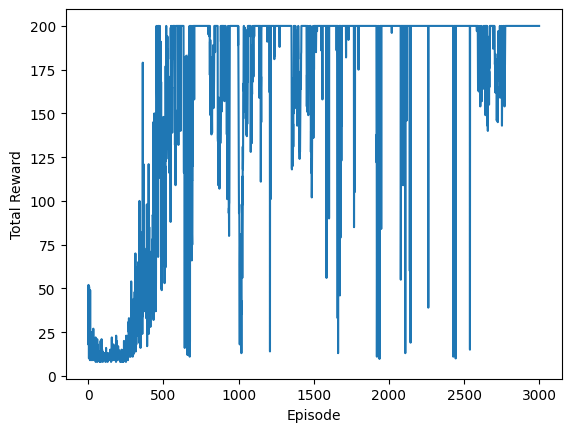

In [8]:
class PolicyNet(Model):
    def __init__(self, action_size=2):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = F.softmax(x)
        return x


class ValueNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x


class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr_pi = 0.0002
        self.lr_v = 0.0005
        self.action_size = 2

        self.pi = PolicyNet()
        self.v = ValueNet()
        self.optimizer_pi = optimizers.Adam(self.lr_pi).setup(self.pi)
        self.optimizer_v = optimizers.Adam(self.lr_v).setup(self.v)

    def get_action(self, state):
        state = state[np.newaxis, :]  # add batch axis
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]

    def update(self, state, action_prob, reward, next_state, done):
        state = state[np.newaxis, :]  # add batch axis
        next_state = next_state[np.newaxis, :]

        """
        target包括v网络,所以要先切换target的反向传播连接,只让loss_v去更新v网络
        delta同理,delta包括v网络,切换delta的连接,只让loss_pi去更新pi网络
        """
        # ========== (1) Update V network ===========
        target = reward + self.gamma * self.v(next_state) * (1 - done)
        target.unchain()
        v = self.v(state)
        loss_v = F.mean_squared_error(v, target)

        # ========== (2) Update pi network ===========
        delta = target - v
        delta.unchain()
        loss_pi = -F.log(action_prob) * delta

        self.v.cleargrads()
        self.pi.cleargrads()
        loss_v.backward()
        loss_pi.backward()
        self.optimizer_v.update()
        self.optimizer_pi.update()


episodes = 3000
env = gym.make('CartPole-v0')
agent = Agent()
reward_history = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.update(state, prob, reward, next_state, done)

        state = next_state
        total_reward += reward

    reward_history.append(total_reward)
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, total_reward))


# plot
plot_total_reward(reward_history)